In [42]:
# Standard scientific Python imports
import matplotlib.pyplot as plt

# Import datasets, classifiers and performance metrics
from sklearn import metrics, svm
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.linear_model import Perceptron, SGDClassifier
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import accuracy_score, log_loss
from itertools import product
import numpy as np

from tqdm import tqdm
from sklearn.svm import SVC

In [43]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms

In [38]:
import sys
import os

parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))

sys.path.append(parent_dir)

from utils import AddGaussianNoise, AddImpulseNoise

# MNIST Dataset

## Data Loading

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

full_data = torch.cat([train_dataset.data, test_dataset.data], dim=0)
full_targets = torch.cat([train_dataset.targets, test_dataset.targets], dim=0)

MNIST_data = full_data.view(len(full_data), -1).numpy().astype('float32') / 255.0

MNIST = {
    "data": MNIST_data,
    "target": full_targets.numpy()
}

Failed to download (trying next):
HTTP Error 404: Not Found



100.0%


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100.0%


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100.0%


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100.0%


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



## Analysis

### (0) Base Case

#### Pre-analysis

In [5]:
# standardization
X_MNIST = StandardScaler().fit_transform(MNIST["data"])
y_MNIST = MNIST["target"]

# Split into train and test
X_train_MNIST, X_test_MNIST, y_train_MNIST, y_test_MNIST = train_test_split(X_MNIST, y_MNIST, test_size=0.2, shuffle=True, random_state=42)

#### Analysis

Let's try as the Vanilla Base Case: Train on the entire dataset using uniform random shuffling for each epoch.

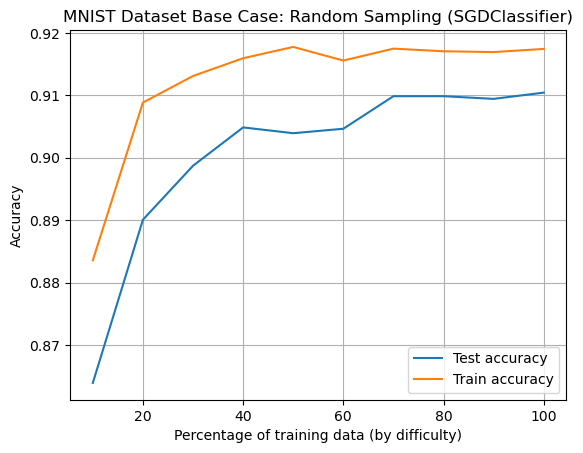

In [6]:
# Shuffle the training data with seed 42
X_shuffled, y_shuffled = shuffle(X_train_MNIST, y_train_MNIST, random_state=42)

difficulty_range = np.linspace(0.1, 1.0, 10)
train_accuracies = []
test_accuracies = []

clf = SGDClassifier(random_state=42)
classes = np.unique(y_train_MNIST)

for percentage in difficulty_range:
    n_samples = int(percentage * len(X_shuffled))
    X_curr = X_shuffled[:n_samples]
    y_curr = y_shuffled[:n_samples]

    clf.partial_fit(X_curr, y_curr, classes=classes)

    train_pred = clf.predict(X_curr)
    test_pred = clf.predict(X_test_MNIST)

    train_accuracies.append(accuracy_score(y_curr, train_pred))
    test_accuracies.append(accuracy_score(y_test_MNIST, test_pred))

# plot results
plt.plot(difficulty_range * 100, test_accuracies, label="Test accuracy")
plt.plot(difficulty_range * 100, train_accuracies, label="Train accuracy")
plt.xlabel("Percentage of training data (by difficulty)")
plt.ylabel("Accuracy")
plt.title("MNIST Dataset Base Case: Random Sampling (SGDClassifier)")
plt.legend()
plt.grid(True)
plt.show()

### (1) Curriculum Learning

#### Pre-analysis

As curriculum learning is based on giving samples in increasing difficulty level to the model, we first need to define a difficulty function. We will base ours on difference between the distance of each point to the line that goes through all the data points.

In [7]:
def compute_MNIST_difficulty(X, y, centroids):
    dist = np.linalg.norm(X - centroids[y], axis=1)
    return dist

In [8]:
percentages = np.linspace(0.75, 1, 5)

#### Analysis

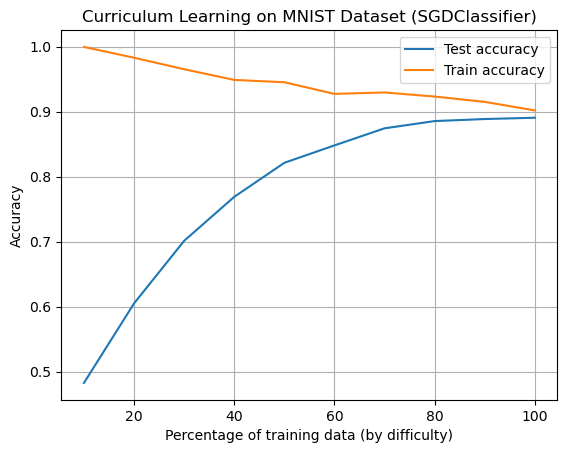

In [11]:
# compute class centroids to later apply the difficulty function
centroids = np.zeros((10, X_train_MNIST.shape[1]))
for i in range(10):
    centroids[i] = X_train_MNIST[y_train_MNIST == i].mean(axis=0)

# normalize the difficulty to [0, 1]
MNIST_difficulty = compute_MNIST_difficulty(X_train_MNIST, y_train_MNIST, centroids)
norm_MNIST_difficulty = (MNIST_difficulty - MNIST_difficulty.min()) / (MNIST_difficulty.max() - MNIST_difficulty.min())

# sort by difficulty
sorted_indices = np.argsort(norm_MNIST_difficulty)
X_sorted = X_train_MNIST[sorted_indices]
y_sorted = y_train_MNIST[sorted_indices]

difficulty_range = np.linspace(0.1, 1.0, 10)
train_accuracies = []
test_accuracies = []

clf = SGDClassifier(random_state=42)
classes = np.unique(y_train_MNIST)

for percentage in difficulty_range:
    n_samples = int(percentage * len(X_sorted))
    X_curr = X_sorted[:n_samples]
    y_curr = y_sorted[:n_samples]

    clf.partial_fit(X_curr, y_curr, classes=classes)

    train_pred = clf.predict(X_curr)
    test_pred = clf.predict(X_test_MNIST)

    train_accuracies.append(accuracy_score(y_curr, train_pred))
    test_accuracies.append(accuracy_score(y_test_MNIST, test_pred))

# plot results
plt.plot(difficulty_range * 100, test_accuracies, label="Test accuracy")
plt.plot(difficulty_range * 100, train_accuracies, label="Train accuracy")
plt.xlabel("Percentage of training data (by difficulty)")
plt.ylabel("Accuracy")
plt.title("Curriculum Learning on MNIST Dataset (SGDClassifier)")
plt.legend()
plt.grid(True)
plt.show()

### (2) Self-Paced Learning

In Self-Paced Learning, the model is supposed to:

• learn from easier samples first (based on current loss)

• adaptively expand its training set to include harder samples as it becomes more confident

We will use the same X_train, X_test, y_train and y_test computed in the curriculum learning phase.
To implement the SPL we will introduce a difficulty threshold to let the model choose how many samples of this difficulty it is ready to handle.

/opt/anaconda3/envs/opti/lib/python3.12/site-packages/sklearn/linear_model/_base.py:395: RuntimeWarning: invalid value encountered in divide
  prob /= prob.sum(axis=1).reshape((prob.shape[0], -1))
/var/folders/rl/9_bwtld11bj9ztyv7_8bh3280000gn/T/ipykernel_37832/726576252.py:33: RuntimeWarning: divide by zero encountered in log
  sample_losses = -np.log(probas[np.arange(len(y_masked)), y_masked])
/opt/anaconda3/envs/opti/lib/python3.12/site-packages/sklearn/linear_model/_base.py:395: RuntimeWarning: invalid value encountered in divide
  prob /= prob.sum(axis=1).reshape((prob.shape[0], -1))
/var/folders/rl/9_bwtld11bj9ztyv7_8bh3280000gn/T/ipykernel_37832/726576252.py:33: RuntimeWarning: divide by zero encountered in log
  sample_losses = -np.log(probas[np.arange(len(y_masked)), y_masked])
/opt/anaconda3/envs/opti/lib/python3.12/site-packages/sklearn/linear_model/_base.py:395: RuntimeWarning: invalid value encountered in divide
  prob /= prob.sum(axis=1).reshape((prob.shape[0], -1))
/var/

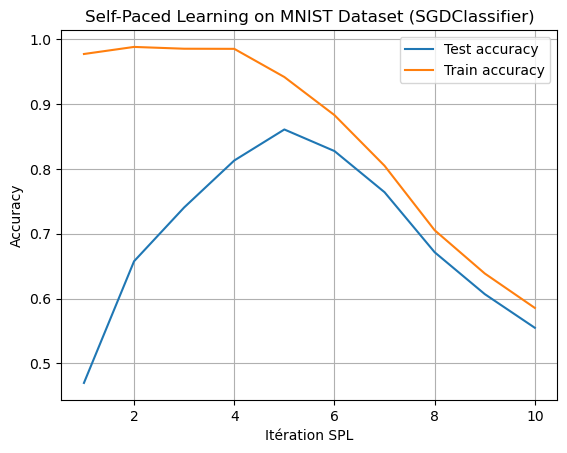

In [20]:
classes = np.unique(y_train_MNIST)

# definition learning parameters
# lambda t : init threshold corresponding to the maximum loss (which then determines difficulty)
# lambda growth : incrementation at every step
# the model is then able to decide how many samples of such difficilty it can handle
max_iters = 10
lambda_t = 0.2
lambda_growth = 0.15

# init training on small random subset
init_size = 50
init_idx = np.random.choice(len(X_train_MNIST), size=init_size, replace=False)
X_curr = X_train_MNIST[init_idx]
y_curr = y_train_MNIST[init_idx]

# remaining pool
mask = np.ones(len(X_train_MNIST), dtype=bool)
mask[init_idx] = False
X_masked = X_train_MNIST[mask]
y_masked = y_train_MNIST[mask]

# initial fit
clf = SGDClassifier(loss="log_loss", random_state=42)
clf.partial_fit(X_curr, y_curr, classes=classes)

train_accuracies = []
test_accuracies = []

for it in range(1, max_iters + 1):
    # calculation probs & loss per sample
    probas = clf.predict_proba(X_masked)
    sample_losses = -np.log(probas[np.arange(len(y_masked)), y_masked])

    filter_mask = sample_losses <= lambda_t
    if not np.any(filter_mask):
        break

    X_filtered = X_masked[filter_mask]
    y_filtered = y_masked[filter_mask]

    X_curr = np.vstack([X_curr, X_filtered])
    y_curr = np.concatenate([y_curr, y_filtered])

    X_masked = X_masked[~filter_mask]
    y_masked = y_masked[~filter_mask]

    clf.partial_fit(X_filtered, y_filtered)

    train_acc = accuracy_score(y_curr, clf.predict(X_curr))
    test_acc = accuracy_score(y_test_MNIST, clf.predict(X_test_MNIST))
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)

    lambda_t += lambda_growth

# tracé des courbes d'apprentissage
plt.plot(range(1, len(test_accuracies)+1), test_accuracies, label="Test accuracy")
plt.plot(range(1, len(train_accuracies)+1), train_accuracies, label="Train accuracy")
plt.xlabel("Itération SPL")
plt.ylabel("Accuracy")
plt.title("Self-Paced Learning on MNIST Dataset (SGDClassifier)")
plt.legend()
plt.grid(True)
plt.show()

### (3) Hard-Example Mining

Hard-Example Mining consists in feeding the model only hard examples. In our case, we will consider that a sample is difficult if its normalized difficulty is greater or equal than 0,75 (in other words the top 25%).

/opt/anaconda3/envs/opti/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/opti/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logisti

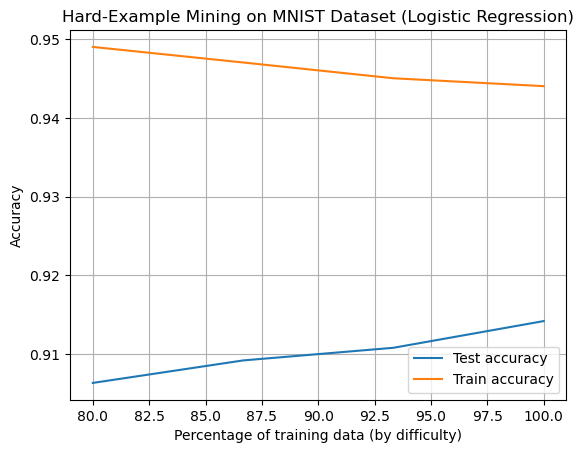

In [21]:
sorted_indices = np.argsort(norm_MNIST_difficulty)
X_sorted = X_MNIST[sorted_indices]
y_sorted = y_MNIST[sorted_indices]

# Curriculum training: increase % of training data
percentages = np.linspace(0.8, 1, 4)
train_accuracies = []
test_accuracies = []

# test set
X_train_all, X_test_MNIST, y_train_all, y_test_MNIST = train_test_split(X_sorted, y_sorted, test_size=0.2, random_state=42)

for percentage in percentages:
    n_samples = int(percentage * len(X_train_all))
    X_train_MNIST = X_train_all[:n_samples]
    y_train_MNIST = y_train_all[:n_samples]
    
    clf = LogisticRegression()
    clf.fit(X_train_MNIST, y_train_MNIST)
    
    train_acc = accuracy_score(y_train_MNIST, clf.predict(X_train_MNIST))
    test_acc = accuracy_score(y_test_MNIST, clf.predict(X_test_MNIST))
    
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)
    
# Plot
plt.plot(percentages * 100, test_accuracies, label="Test accuracy")
plt.plot(percentages * 100, train_accuracies, label="Train accuracy")
plt.xlabel("Percentage of training data (by difficulty)")
plt.ylabel("Accuracy")
plt.title("Hard-Example Mining on MNIST Dataset (Logistic Regression)")
plt.legend()
plt.grid(True)
plt.show()

### (4) Reverse Curriculum Learning

We are implementing **Reverse Curriculum Learning (RCL)** where the model starts learning from easier goals that are close to the target and gradually works backwards to more challenging starting states.

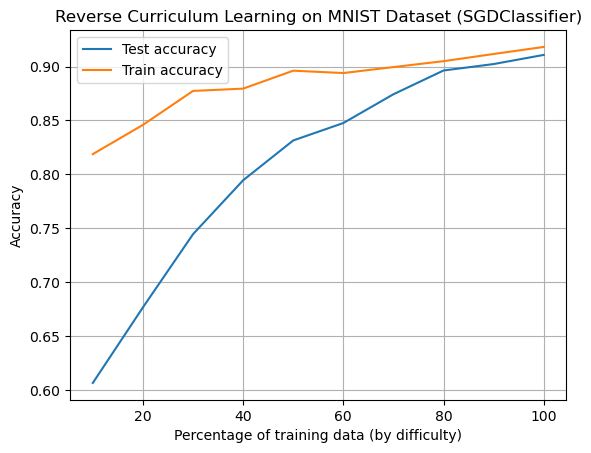

In [23]:
# compute class centroids to later apply the difficulty function
centroids = np.zeros((10, X_train_MNIST.shape[1]))
for i in range(10):
    centroids[i] = X_train_MNIST[y_train_MNIST == i].mean(axis=0)

# normalize the difficulty to [0, 1]
MNIST_difficulty = compute_MNIST_difficulty(X_train_MNIST, y_train_MNIST, centroids)
norm_MNIST_difficulty = (MNIST_difficulty - MNIST_difficulty.min()) / (MNIST_difficulty.max() - MNIST_difficulty.min())

# sort by difficulty
sorted_indices = np.argsort(norm_MNIST_difficulty)[::-1] ## Reverse order for RCL
X_sorted = X_train_MNIST[sorted_indices]
y_sorted = y_train_MNIST[sorted_indices]

difficulty_range = np.linspace(0.1, 1.0, 10)
train_accuracies = []
test_accuracies = []

clf = SGDClassifier(random_state=42)
classes = np.unique(y_train_MNIST)

for percentage in difficulty_range:
    n_samples = int(percentage * len(X_sorted))
    X_curr = X_sorted[:n_samples]
    y_curr = y_sorted[:n_samples]

    clf.partial_fit(X_curr, y_curr, classes=classes)

    train_pred = clf.predict(X_curr)
    test_pred = clf.predict(X_test_MNIST)

    train_accuracies.append(accuracy_score(y_curr, train_pred))
    test_accuracies.append(accuracy_score(y_test_MNIST, test_pred))

# plot results
plt.plot(difficulty_range * 100, test_accuracies, label="Test accuracy")
plt.plot(difficulty_range * 100, train_accuracies, label="Train accuracy")
plt.xlabel("Percentage of training data (by difficulty)")
plt.ylabel("Accuracy")
plt.title("Reverse Curriculum Learning on MNIST Dataset (SGDClassifier)")
plt.legend()
plt.grid(True)
plt.show()

### (5) Stratified Monte-Carlo Sampling

**Stratified Monte Carlo Sampling** is a variance reduction technique where the input space is divided into distinct strata (subregions), and samples are drawn from each stratum. This ensures more uniform coverage of the space compared to standard Monte Carlo sampling, leading to more accurate and stable estimates with fewer samples.

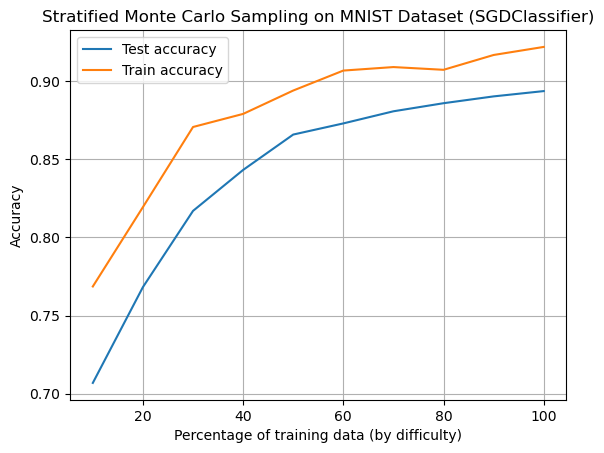

In [25]:
# compute difficulty and normalize it
centroids = np.zeros((10, X_train_MNIST.shape[1]))
for i in range(10):
    centroids[i] = X_train_MNIST[y_train_MNIST == i].mean(axis=0)

MNIST_difficulty = compute_MNIST_difficulty(X_train_MNIST, y_train_MNIST, centroids)
norm_MNIST_difficulty = (MNIST_difficulty - MNIST_difficulty.min()) / (MNIST_difficulty.max() - MNIST_difficulty.min())

# stratify based on difficulty
n_strata = 10
strata_bounds = np.linspace(0, 1, n_strata + 1)
strata_indices = [np.where((norm_MNIST_difficulty >= strata_bounds[i]) & 
                           (norm_MNIST_difficulty < strata_bounds[i+1]))[0]
                  for i in range(n_strata)]

# training over growing percentages of the dataset
difficulty_range = np.linspace(0.1, 1.0, 10)
train_accuracies = []
test_accuracies = []

clf = SGDClassifier(random_state=42)
classes = np.unique(y_train_MNIST)

for percentage in difficulty_range:
    n_total_samples = int(percentage * len(X_train_MNIST))
    n_per_stratum = n_total_samples // n_strata

    selected_indices = []
    for indices in strata_indices:
        if len(indices) == 0:
            continue
        stratum_sample = np.random.choice(indices, min(n_per_stratum, len(indices)), replace=False)
        selected_indices.extend(stratum_sample)

    X_curr = X_train_MNIST[selected_indices]
    y_curr = y_train_MNIST[selected_indices]

    clf.partial_fit(X_curr, y_curr, classes=classes)

    train_pred = clf.predict(X_curr)
    test_pred = clf.predict(X_test_MNIST)

    train_accuracies.append(accuracy_score(y_curr, train_pred))
    test_accuracies.append(accuracy_score(y_test_MNIST, test_pred))

# plot results
plt.plot(difficulty_range * 100, test_accuracies, label="Test accuracy")
plt.plot(difficulty_range * 100, train_accuracies, label="Train accuracy")
plt.xlabel("Percentage of training data (by difficulty)")
plt.ylabel("Accuracy")
plt.title("Stratified Monte Carlo Sampling on MNIST Dataset (SGDClassifier)")
plt.legend()
plt.grid(True)
plt.show()

# MNIST Dataset with Gaussian Noise

## Data Loading

In [44]:
transform = transforms.Compose([
    transforms.ToTensor(),
    AddGaussianNoise(noise_level=0.3)
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

full_data = torch.cat([train_dataset.data, test_dataset.data], dim=0)
full_targets = torch.cat([train_dataset.targets, test_dataset.targets], dim=0)

MNIST_data = full_data.view(len(full_data), -1).numpy().astype('float32') / 255.0

MNIST_GN = {
    "data": MNIST_data,
    "target": full_targets.numpy()
}

## Analysis

### (0) Base Case

#### Pre-analysis

In [45]:
# standardization
X_MNIST_GN = StandardScaler().fit_transform(MNIST_GN["data"])
y_MNIST_GN = MNIST_GN["target"]

# Split into train and test
X_train_MNIST_GN, X_test_MNIST_GN, y_train_MNIST_GN, y_test_MNIST_GN = train_test_split(X_MNIST_GN, y_MNIST_GN, test_size=0.2, shuffle=True, random_state=42)

#### Analysis

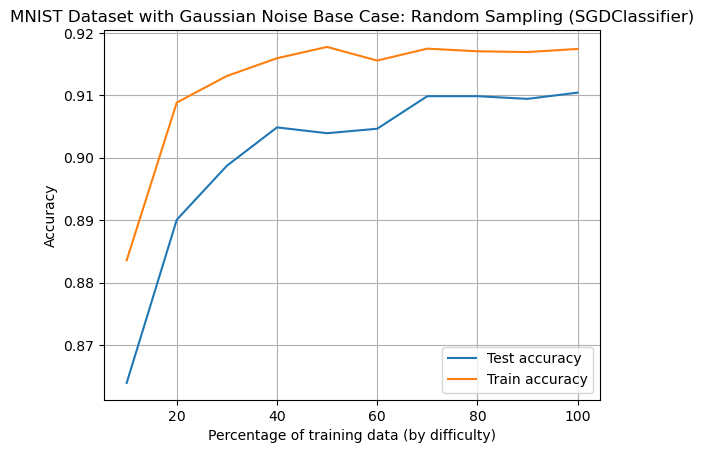

In [46]:
# Shuffle the training data with seed 42
X_shuffled, y_shuffled = shuffle(X_train_MNIST_GN, y_train_MNIST_GN, random_state=42)

difficulty_range = np.linspace(0.1, 1.0, 10)
train_accuracies = []
test_accuracies = []

clf = SGDClassifier(random_state=42)
classes = np.unique(y_train_MNIST_GN)

for percentage in difficulty_range:
    n_samples = int(percentage * len(X_shuffled))
    X_curr = X_shuffled[:n_samples]
    y_curr = y_shuffled[:n_samples]

    clf.partial_fit(X_curr, y_curr, classes=classes)

    train_pred = clf.predict(X_curr)
    test_pred = clf.predict(X_test_MNIST_GN)

    train_accuracies.append(accuracy_score(y_curr, train_pred))
    test_accuracies.append(accuracy_score(y_test_MNIST_GN, test_pred))

# plot results
plt.plot(difficulty_range * 100, test_accuracies, label="Test accuracy")
plt.plot(difficulty_range * 100, train_accuracies, label="Train accuracy")
plt.xlabel("Percentage of training data (by difficulty)")
plt.ylabel("Accuracy")
plt.title("MNIST Dataset with Gaussian Noise Base Case: Random Sampling (SGDClassifier)")
plt.legend()
plt.grid(True)
plt.show()

### (1) Curriculum Learning

#### Pre-Analysis

In [47]:
def compute_MNIST_difficulty(X, y, centroids):
    dist = np.linalg.norm(X - centroids[y], axis=1)
    return dist

In [48]:
percentages = np.linspace(0.75, 1, 5)

#### Analysis

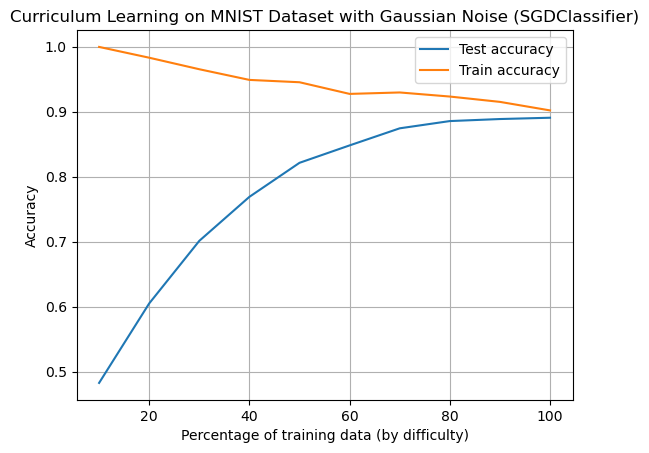

In [49]:
# compute class centroids to later apply the difficulty function
centroids = np.zeros((10, X_train_MNIST_GN.shape[1]))
for i in range(10):
    centroids[i] = X_train_MNIST_GN[y_train_MNIST_GN == i].mean(axis=0)

# normalize the difficulty to [0, 1]
MNIST_difficulty = compute_MNIST_difficulty(X_train_MNIST_GN, y_train_MNIST_GN, centroids)
norm_MNIST_difficulty = (MNIST_difficulty - MNIST_difficulty.min()) / (MNIST_difficulty.max() - MNIST_difficulty.min())

# sort by difficulty
sorted_indices = np.argsort(norm_MNIST_difficulty)
X_sorted = X_train_MNIST_GN[sorted_indices]
y_sorted = y_train_MNIST_GN[sorted_indices]

difficulty_range = np.linspace(0.1, 1.0, 10)
train_accuracies = []
test_accuracies = []

clf = SGDClassifier(random_state=42)
classes = np.unique(y_train_MNIST_GN)

for percentage in difficulty_range:
    n_samples = int(percentage * len(X_sorted))
    X_curr = X_sorted[:n_samples]
    y_curr = y_sorted[:n_samples]

    clf.partial_fit(X_curr, y_curr, classes=classes)

    train_pred = clf.predict(X_curr)
    test_pred = clf.predict(X_test_MNIST_GN)

    train_accuracies.append(accuracy_score(y_curr, train_pred))
    test_accuracies.append(accuracy_score(y_test_MNIST_GN, test_pred))

# Plot results
plt.plot(difficulty_range * 100, test_accuracies, label="Test accuracy")
plt.plot(difficulty_range * 100, train_accuracies, label="Train accuracy")
plt.xlabel("Percentage of training data (by difficulty)")
plt.ylabel("Accuracy")
plt.title("Curriculum Learning on MNIST Dataset with Gaussian Noise (SGDClassifier)")
plt.legend()
plt.grid(True)
plt.show()

### (2) Self-Paced Learning

We will use the same X_train, X_test, y_train and y_test computed in the curriculum learning phase.
To implement the SPL we will introduce a difficulty threshold to let the model choose how many samples of this difficulty it is ready to handle.

/opt/anaconda3/envs/opti/lib/python3.12/site-packages/sklearn/linear_model/_base.py:395: RuntimeWarning: invalid value encountered in divide
  prob /= prob.sum(axis=1).reshape((prob.shape[0], -1))
/var/folders/rl/9_bwtld11bj9ztyv7_8bh3280000gn/T/ipykernel_37832/86746683.py:33: RuntimeWarning: divide by zero encountered in log
  sample_losses = -np.log(probas[np.arange(len(y_masked)), y_masked])
/opt/anaconda3/envs/opti/lib/python3.12/site-packages/sklearn/linear_model/_base.py:395: RuntimeWarning: invalid value encountered in divide
  prob /= prob.sum(axis=1).reshape((prob.shape[0], -1))
/var/folders/rl/9_bwtld11bj9ztyv7_8bh3280000gn/T/ipykernel_37832/86746683.py:33: RuntimeWarning: divide by zero encountered in log
  sample_losses = -np.log(probas[np.arange(len(y_masked)), y_masked])
/opt/anaconda3/envs/opti/lib/python3.12/site-packages/sklearn/linear_model/_base.py:395: RuntimeWarning: invalid value encountered in divide
  prob /= prob.sum(axis=1).reshape((prob.shape[0], -1))
/var/fo

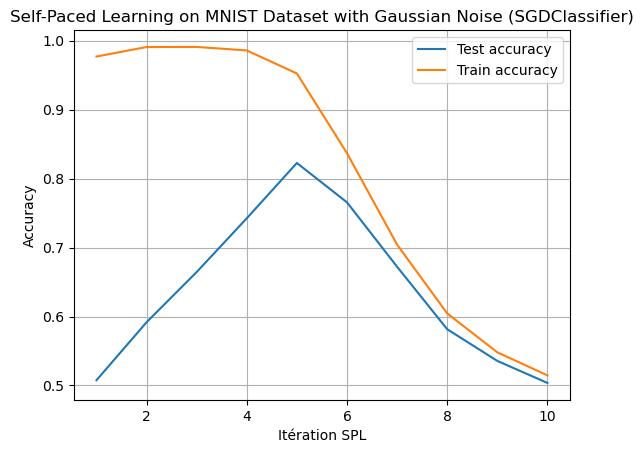

In [51]:
classes = np.unique(y_train_MNIST_GN)

# definition learning parameters
# lambda t : init threshold corresponding to the maximum loss (which then determines difficulty)
# lambda growth : incrementation at every step
# the model is then able to decide how many samples of such difficilty it can handle
max_iters = 10
lambda_t = 0.2
lambda_growth = 0.15

# init training on small random subset
init_size = 50
init_idx = np.random.choice(len(X_train_MNIST_GN), size=init_size, replace=False)
X_curr = X_train_MNIST_GN[init_idx]
y_curr = y_train_MNIST_GN[init_idx]

# remaining pool
mask = np.ones(len(X_train_MNIST_GN), dtype=bool)
mask[init_idx] = False
X_masked = X_train_MNIST_GN[mask]
y_masked = y_train_MNIST_GN[mask]

# initial fit
clf = SGDClassifier(loss="log_loss", random_state=42)
clf.partial_fit(X_curr, y_curr, classes=classes)

train_accuracies = []
test_accuracies = []

for it in range(1, max_iters + 1):
    # calculation probs & loss per sample
    probas = clf.predict_proba(X_masked)
    sample_losses = -np.log(probas[np.arange(len(y_masked)), y_masked])

    filter_mask = sample_losses <= lambda_t
    if not np.any(filter_mask):
        break

    X_filtered = X_masked[filter_mask]
    y_filtered = y_masked[filter_mask]

    X_curr = np.vstack([X_curr, X_filtered])
    y_curr = np.concatenate([y_curr, y_filtered])

    X_masked = X_masked[~filter_mask]
    y_masked = y_masked[~filter_mask]

    clf.partial_fit(X_filtered, y_filtered)

    train_acc = accuracy_score(y_curr, clf.predict(X_curr))
    test_acc = accuracy_score(y_test_MNIST_GN, clf.predict(X_test_MNIST_GN))
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)

    lambda_t += lambda_growth

# tracé des courbes d'apprentissage
plt.plot(range(1, len(test_accuracies)+1), test_accuracies, label="Test accuracy")
plt.plot(range(1, len(train_accuracies)+1), train_accuracies, label="Train accuracy")
plt.xlabel("Itération SPL")
plt.ylabel("Accuracy")
plt.title("Self-Paced Learning on MNIST Dataset with Gaussian Noise (SGDClassifier)")
plt.legend()
plt.grid(True)
plt.show()

### (3) Hard-Example Mining

/opt/anaconda3/envs/opti/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/opti/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logisti

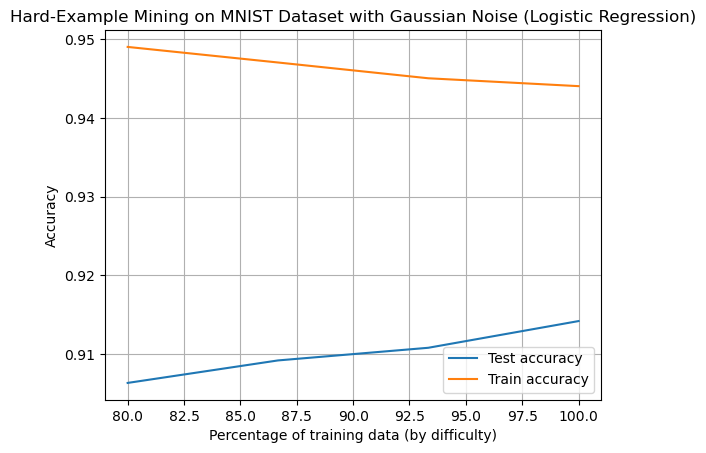

In [52]:
sorted_indices = np.argsort(norm_MNIST_difficulty)
X_sorted = X_MNIST_GN[sorted_indices]
y_sorted = y_MNIST_GN[sorted_indices]

# Curriculum training: increase % of training data
percentages = np.linspace(0.8, 1, 4)
train_accuracies = []
test_accuracies = []

# test set
X_train_all, X_test_MNIST_GN, y_train_all, y_test_MNIST_GN = train_test_split(X_sorted, y_sorted, test_size=0.2, random_state=42)

for percentage in percentages:
    n_samples = int(percentage * len(X_train_all))
    X_train_MNIST_GN = X_train_all[:n_samples]
    y_train_MNIST_GN = y_train_all[:n_samples]
    
    clf = LogisticRegression()
    clf.fit(X_train_MNIST_GN, y_train_MNIST_GN)
    
    train_acc = accuracy_score(y_train_MNIST_GN, clf.predict(X_train_MNIST_GN))
    test_acc = accuracy_score(y_test_MNIST_GN, clf.predict(X_test_MNIST_GN))
    
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)
    
# Plot
plt.plot(percentages * 100, test_accuracies, label="Test accuracy")
plt.plot(percentages * 100, train_accuracies, label="Train accuracy")
plt.xlabel("Percentage of training data (by difficulty)")
plt.ylabel("Accuracy")
plt.title("Hard-Example Mining on MNIST Dataset with Gaussian Noise (Logistic Regression)")
plt.legend()
plt.grid(True)
plt.show()

### (4) Reverse Curriculum Learning

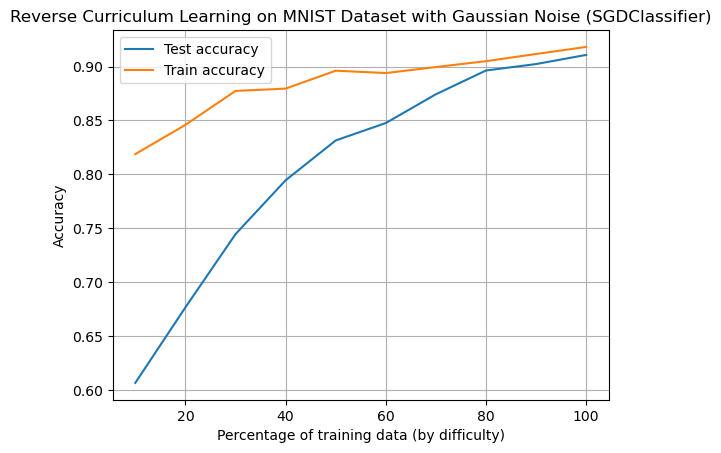

In [54]:
# compute class centroids to later apply the difficulty function
centroids = np.zeros((10, X_train_MNIST_GN.shape[1]))
for i in range(10):
    centroids[i] = X_train_MNIST_GN[y_train_MNIST_GN == i].mean(axis=0)

# normalize the difficulty to [0, 1]
MNIST_difficulty = compute_MNIST_difficulty(X_train_MNIST_GN, y_train_MNIST_GN, centroids)
norm_MNIST_difficulty = (MNIST_difficulty - MNIST_difficulty.min()) / (MNIST_difficulty.max() - MNIST_difficulty.min())

# sort by difficulty
sorted_indices = np.argsort(norm_MNIST_difficulty)[::-1] ## Reverse order for RCL
X_sorted = X_train_MNIST_GN[sorted_indices]
y_sorted = y_train_MNIST_GN[sorted_indices]

difficulty_range = np.linspace(0.1, 1.0, 10)
train_accuracies = []
test_accuracies = []

clf = SGDClassifier(random_state=42)
classes = np.unique(y_train_MNIST_GN)

for percentage in difficulty_range:
    n_samples = int(percentage * len(X_sorted))
    X_curr = X_sorted[:n_samples]
    y_curr = y_sorted[:n_samples]

    clf.partial_fit(X_curr, y_curr, classes=classes)

    train_pred = clf.predict(X_curr)
    test_pred = clf.predict(X_test_MNIST_GN)

    train_accuracies.append(accuracy_score(y_curr, train_pred))
    test_accuracies.append(accuracy_score(y_test_MNIST_GN, test_pred))

# plot results
plt.plot(difficulty_range * 100, test_accuracies, label="Test accuracy")
plt.plot(difficulty_range * 100, train_accuracies, label="Train accuracy")
plt.xlabel("Percentage of training data (by difficulty)")
plt.ylabel("Accuracy")
plt.title("Reverse Curriculum Learning on MNIST Dataset with Gaussian Noise (SGDClassifier)")
plt.legend()
plt.grid(True)
plt.show()

### (5) Stratified Monte-Carlo Sampling

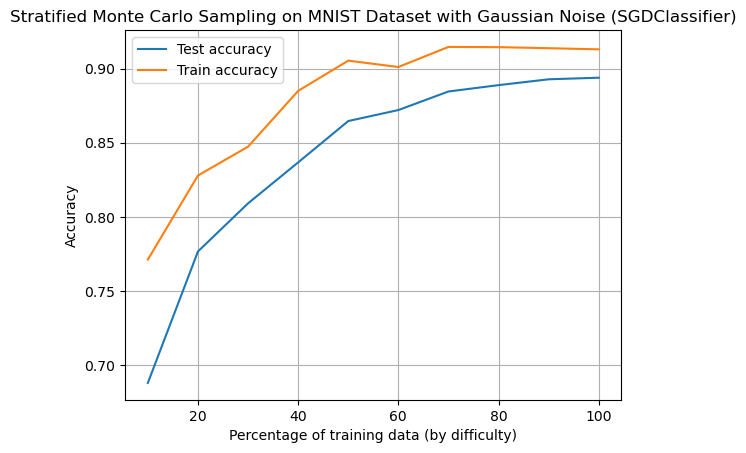

In [56]:
# compute difficulty and normalize it
centroids = np.zeros((10, X_train_MNIST_GN.shape[1]))
for i in range(10):
    centroids[i] = X_train_MNIST_GN[y_train_MNIST_GN == i].mean(axis=0)

MNIST_difficulty = compute_MNIST_difficulty(X_train_MNIST_GN, y_train_MNIST_GN, centroids)
norm_MNIST_difficulty = (MNIST_difficulty - MNIST_difficulty.min()) / (MNIST_difficulty.max() - MNIST_difficulty.min())

# stratify based on difficulty
n_strata = 10
strata_bounds = np.linspace(0, 1, n_strata + 1)
strata_indices = [np.where((norm_MNIST_difficulty >= strata_bounds[i]) & 
                           (norm_MNIST_difficulty < strata_bounds[i+1]))[0]
                  for i in range(n_strata)]

# training over growing percentages of the dataset
difficulty_range = np.linspace(0.1, 1.0, 10)
train_accuracies = []
test_accuracies = []

clf = SGDClassifier(random_state=42)
classes = np.unique(y_train_MNIST_GN)

for percentage in difficulty_range:
    n_total_samples = int(percentage * len(X_train_MNIST_GN))
    n_per_stratum = n_total_samples // n_strata

    selected_indices = []
    for indices in strata_indices:
        if len(indices) == 0:
            continue
        stratum_sample = np.random.choice(indices, min(n_per_stratum, len(indices)), replace=False)
        selected_indices.extend(stratum_sample)

    X_curr = X_train_MNIST_GN[selected_indices]
    y_curr = y_train_MNIST_GN[selected_indices]

    clf.partial_fit(X_curr, y_curr, classes=classes)

    train_pred = clf.predict(X_curr)
    test_pred = clf.predict(X_test_MNIST_GN)

    train_accuracies.append(accuracy_score(y_curr, train_pred))
    test_accuracies.append(accuracy_score(y_test_MNIST_GN, test_pred))

# plot results
plt.plot(difficulty_range * 100, test_accuracies, label="Test accuracy")
plt.plot(difficulty_range * 100, train_accuracies, label="Train accuracy")
plt.xlabel("Percentage of training data (by difficulty)")
plt.ylabel("Accuracy")
plt.title("Stratified Monte Carlo Sampling on MNIST Dataset with Gaussian Noise (SGDClassifier)")
plt.legend()
plt.grid(True)
plt.show()

# MNIST Dataset with Impulse Noise

## Data Loading

In [58]:
transform = transforms.Compose([
    transforms.ToTensor(),
    AddImpulseNoise(probability=0.3)
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

full_data = torch.cat([train_dataset.data, test_dataset.data], dim=0)
full_targets = torch.cat([train_dataset.targets, test_dataset.targets], dim=0)

MNIST_data = full_data.view(len(full_data), -1).numpy().astype('float32') / 255.0

MNIST_IN = {
    "data": MNIST_data,
    "target": full_targets.numpy()
}

## Analysis

### (0) Base Case

#### Pre-analysis

In [59]:
# standardization
X_MNIST_IN = StandardScaler().fit_transform(MNIST_IN["data"])
y_MNIST_IN = MNIST_IN["target"]

# Split into train and test
X_train_MNIST_IN, X_test_MNIST_IN, y_train_MNIST_IN, y_test_MNIST_IN = train_test_split(X_MNIST_IN, y_MNIST_IN, test_size=0.2, shuffle=True, random_state=42)

#### Analysis

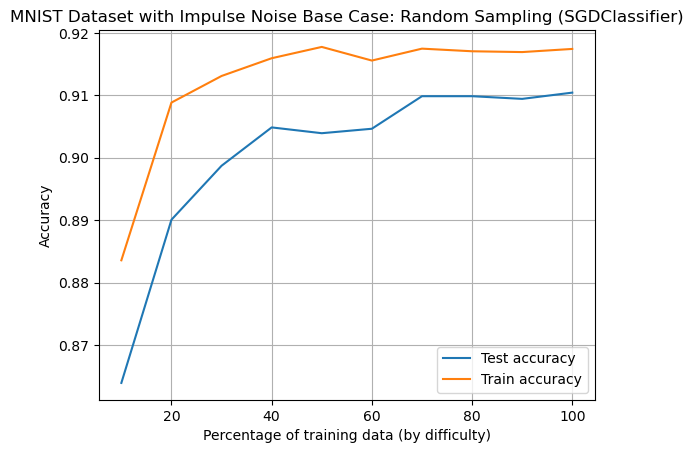

In [60]:
# Shuffle the training data with seed 42
X_shuffled, y_shuffled = shuffle(X_train_MNIST_IN, y_train_MNIST_IN, random_state=42)

difficulty_range = np.linspace(0.1, 1.0, 10)
train_accuracies = []
test_accuracies = []

clf = SGDClassifier(random_state=42)
classes = np.unique(y_train_MNIST_IN)

for percentage in difficulty_range:
    n_samples = int(percentage * len(X_shuffled))
    X_curr = X_shuffled[:n_samples]
    y_curr = y_shuffled[:n_samples]

    clf.partial_fit(X_curr, y_curr, classes=classes)

    train_pred = clf.predict(X_curr)
    test_pred = clf.predict(X_test_MNIST_IN)

    train_accuracies.append(accuracy_score(y_curr, train_pred))
    test_accuracies.append(accuracy_score(y_test_MNIST_IN, test_pred))

# plot results
plt.plot(difficulty_range * 100, test_accuracies, label="Test accuracy")
plt.plot(difficulty_range * 100, train_accuracies, label="Train accuracy")
plt.xlabel("Percentage of training data (by difficulty)")
plt.ylabel("Accuracy")
plt.title("MNIST Dataset with Impulse Noise Base Case: Random Sampling (SGDClassifier)")
plt.legend()
plt.grid(True)
plt.show()

### (1) Curriculum Learning

#### Pre-analysis

In [61]:
def compute_MNIST_difficulty(X, y, centroids):
    dist = np.linalg.norm(X - centroids[y], axis=1)
    return dist

In [62]:
percentages = np.linspace(0.75, 1, 5)

#### Analysis

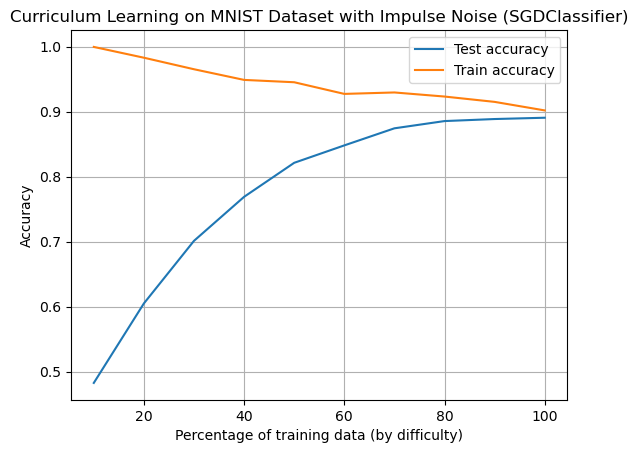

In [63]:
# compute class centroids to later apply the difficulty function
centroids = np.zeros((10, X_train_MNIST_IN.shape[1]))
for i in range(10):
    centroids[i] = X_train_MNIST_IN[y_train_MNIST_IN == i].mean(axis=0)

# normalize the difficulty to [0, 1]
MNIST_difficulty = compute_MNIST_difficulty(X_train_MNIST_IN, y_train_MNIST_IN, centroids)
norm_MNIST_difficulty = (MNIST_difficulty - MNIST_difficulty.min()) / (MNIST_difficulty.max() - MNIST_difficulty.min())

# sort by difficulty
sorted_indices = np.argsort(norm_MNIST_difficulty)
X_sorted = X_train_MNIST_IN[sorted_indices]
y_sorted = y_train_MNIST_IN[sorted_indices]

difficulty_range = np.linspace(0.1, 1.0, 10)
train_accuracies = []
test_accuracies = []

clf = SGDClassifier(random_state=42)
classes = np.unique(y_train_MNIST_IN)

for percentage in difficulty_range:
    n_samples = int(percentage * len(X_sorted))
    X_curr = X_sorted[:n_samples]
    y_curr = y_sorted[:n_samples]

    clf.partial_fit(X_curr, y_curr, classes=classes)

    train_pred = clf.predict(X_curr)
    test_pred = clf.predict(X_test_MNIST_IN)

    train_accuracies.append(accuracy_score(y_curr, train_pred))
    test_accuracies.append(accuracy_score(y_test_MNIST_IN, test_pred))

# Plot results
plt.plot(difficulty_range * 100, test_accuracies, label="Test accuracy")
plt.plot(difficulty_range * 100, train_accuracies, label="Train accuracy")
plt.xlabel("Percentage of training data (by difficulty)")
plt.ylabel("Accuracy")
plt.title("Curriculum Learning on MNIST Dataset with Impulse Noise (SGDClassifier)")
plt.legend()
plt.grid(True)
plt.show()

### (2) Self-Paced Learning

We will use the same X_train, X_test, y_train and y_test computed in the curriculum learning phase.
To implement the SPL we will introduce a difficulty threshold to let the model choose how many samples of this difficulty it is ready to handle.

/opt/anaconda3/envs/opti/lib/python3.12/site-packages/sklearn/linear_model/_base.py:395: RuntimeWarning: invalid value encountered in divide
  prob /= prob.sum(axis=1).reshape((prob.shape[0], -1))
/var/folders/rl/9_bwtld11bj9ztyv7_8bh3280000gn/T/ipykernel_37832/1791135984.py:33: RuntimeWarning: divide by zero encountered in log
  sample_losses = -np.log(probas[np.arange(len(y_masked)), y_masked])
/opt/anaconda3/envs/opti/lib/python3.12/site-packages/sklearn/linear_model/_base.py:395: RuntimeWarning: invalid value encountered in divide
  prob /= prob.sum(axis=1).reshape((prob.shape[0], -1))
/var/folders/rl/9_bwtld11bj9ztyv7_8bh3280000gn/T/ipykernel_37832/1791135984.py:33: RuntimeWarning: divide by zero encountered in log
  sample_losses = -np.log(probas[np.arange(len(y_masked)), y_masked])
/opt/anaconda3/envs/opti/lib/python3.12/site-packages/sklearn/linear_model/_base.py:395: RuntimeWarning: invalid value encountered in divide
  prob /= prob.sum(axis=1).reshape((prob.shape[0], -1))
/va

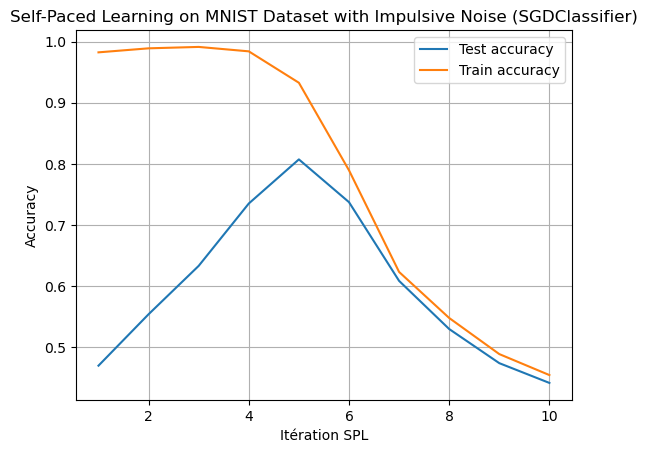

In [68]:
classes = np.unique(y_train_MNIST_IN)

# definition learning parameters
# lambda t : init threshold corresponding to the maximum loss (which then determines difficulty)
# lambda growth : incrementation at every step
# the model is then able to decide how many samples of such difficilty it can handle
max_iters = 10
lambda_t = 0.2
lambda_growth = 0.15

# init training on small random subset
init_size = 50
init_idx = np.random.choice(len(X_train_MNIST_IN), size=init_size, replace=False)
X_curr = X_train_MNIST_IN[init_idx]
y_curr = y_train_MNIST_IN[init_idx]

# remaining pool
mask = np.ones(len(X_train_MNIST_IN), dtype=bool)
mask[init_idx] = False
X_masked = X_train_MNIST_IN[mask]
y_masked = y_train_MNIST_IN[mask]

# initial fit
clf = SGDClassifier(loss="log_loss", random_state=42)
clf.partial_fit(X_curr, y_curr, classes=classes)

train_accuracies = []
test_accuracies = []

for it in range(1, max_iters + 1):
    # calculation probs & loss per sample
    probas = clf.predict_proba(X_masked)
    sample_losses = -np.log(probas[np.arange(len(y_masked)), y_masked])

    filter_mask = sample_losses <= lambda_t
    if not np.any(filter_mask):
        break

    X_filtered = X_masked[filter_mask]
    y_filtered = y_masked[filter_mask]

    X_curr = np.vstack([X_curr, X_filtered])
    y_curr = np.concatenate([y_curr, y_filtered])

    X_masked = X_masked[~filter_mask]
    y_masked = y_masked[~filter_mask]

    clf.partial_fit(X_filtered, y_filtered)

    train_acc = accuracy_score(y_curr, clf.predict(X_curr))
    test_acc = accuracy_score(y_test_MNIST_IN, clf.predict(X_test_MNIST_IN))
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)

    lambda_t += lambda_growth

# tracé des courbes d'apprentissage
plt.plot(range(1, len(test_accuracies)+1), test_accuracies, label="Test accuracy")
plt.plot(range(1, len(train_accuracies)+1), train_accuracies, label="Train accuracy")
plt.xlabel("Itération SPL")
plt.ylabel("Accuracy")
plt.title("Self-Paced Learning on MNIST Dataset with Impulsive Noise (SGDClassifier)")
plt.legend()
plt.grid(True)
plt.show()

### (3) Hard-Example Mining

/opt/anaconda3/envs/opti/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/opti/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logisti

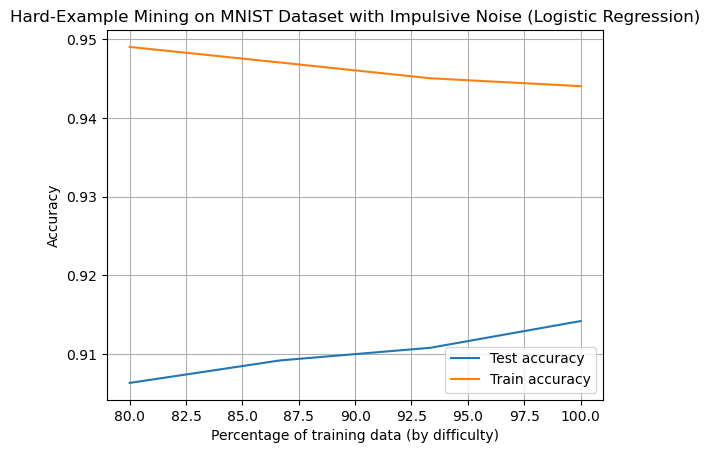

In [66]:
sorted_indices = np.argsort(norm_MNIST_difficulty)
X_sorted = X_MNIST_IN[sorted_indices]
y_sorted = y_MNIST_IN[sorted_indices]

# Curriculum training: increase % of training data
percentages = np.linspace(0.8, 1, 4)
train_accuracies = []
test_accuracies = []

# test set
X_train_all, X_test_MNIST_IN, y_train_all, y_test_MNIST_IN = train_test_split(X_sorted, y_sorted, test_size=0.2, random_state=42)

for percentage in percentages:
    n_samples = int(percentage * len(X_train_all))
    X_train_MNIST_IN = X_train_all[:n_samples]
    y_train_MNIST_IN = y_train_all[:n_samples]
    
    clf = LogisticRegression()
    clf.fit(X_train_MNIST_IN, y_train_MNIST_IN)
    
    train_acc = accuracy_score(y_train_MNIST_IN, clf.predict(X_train_MNIST_IN))
    test_acc = accuracy_score(y_test_MNIST_IN, clf.predict(X_test_MNIST_IN))
    
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)
    
# Plot
plt.plot(percentages * 100, test_accuracies, label="Test accuracy")
plt.plot(percentages * 100, train_accuracies, label="Train accuracy")
plt.xlabel("Percentage of training data (by difficulty)")
plt.ylabel("Accuracy")
plt.title("Hard-Example Mining on MNIST Dataset with Impulsive Noise (Logistic Regression)")
plt.legend()
plt.grid(True)
plt.show()

### (4) Reverse Curriculum Learning

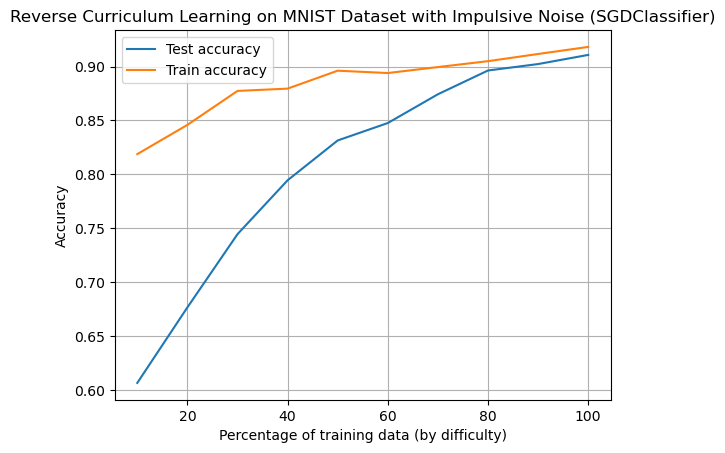

In [70]:
# compute class centroids to later apply the difficulty function
centroids = np.zeros((10, X_train_MNIST_IN.shape[1]))
for i in range(10):
    centroids[i] = X_train_MNIST_IN[y_train_MNIST_IN == i].mean(axis=0)

# normalize the difficulty to [0, 1]
MNIST_difficulty = compute_MNIST_difficulty(X_train_MNIST_IN, y_train_MNIST_IN, centroids)
norm_MNIST_difficulty = (MNIST_difficulty - MNIST_difficulty.min()) / (MNIST_difficulty.max() - MNIST_difficulty.min())

# sort by difficulty
sorted_indices = np.argsort(norm_MNIST_difficulty)[::-1] ## Reverse order for RCL
X_sorted = X_train_MNIST_IN[sorted_indices]
y_sorted = y_train_MNIST_IN[sorted_indices]

difficulty_range = np.linspace(0.1, 1.0, 10)
train_accuracies = []
test_accuracies = []

clf = SGDClassifier(random_state=42)
classes = np.unique(y_train_MNIST_IN)

for percentage in difficulty_range:
    n_samples = int(percentage * len(X_sorted))
    X_curr = X_sorted[:n_samples]
    y_curr = y_sorted[:n_samples]

    clf.partial_fit(X_curr, y_curr, classes=classes)

    train_pred = clf.predict(X_curr)
    test_pred = clf.predict(X_test_MNIST_IN)

    train_accuracies.append(accuracy_score(y_curr, train_pred))
    test_accuracies.append(accuracy_score(y_test_MNIST_IN, test_pred))

# plot results
plt.plot(difficulty_range * 100, test_accuracies, label="Test accuracy")
plt.plot(difficulty_range * 100, train_accuracies, label="Train accuracy")
plt.xlabel("Percentage of training data (by difficulty)")
plt.ylabel("Accuracy")
plt.title("Reverse Curriculum Learning on MNIST Dataset with Impulsive Noise (SGDClassifier)")
plt.legend()
plt.grid(True)
plt.show()

### (5) Stratified Monte-Carlo Sampling

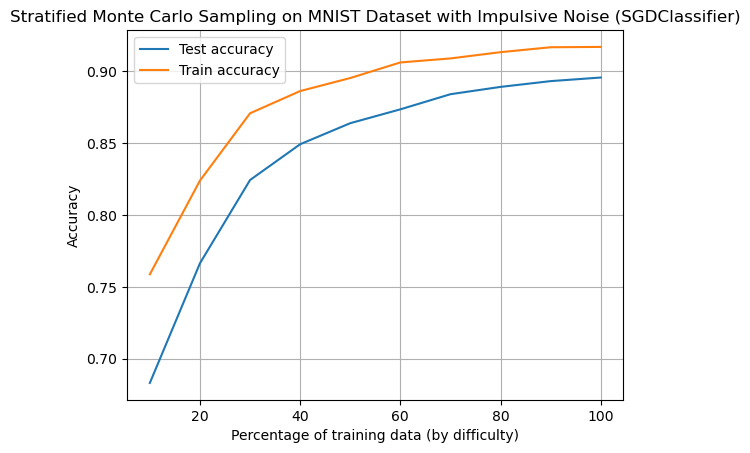

In [72]:
# compute difficulty and normalize it
centroids = np.zeros((10, X_train_MNIST_IN.shape[1]))
for i in range(10):
    centroids[i] = X_train_MNIST_IN[y_train_MNIST_IN == i].mean(axis=0)

MNIST_difficulty = compute_MNIST_difficulty(X_train_MNIST_IN, y_train_MNIST_IN, centroids)
norm_MNIST_difficulty = (MNIST_difficulty - MNIST_difficulty.min()) / (MNIST_difficulty.max() - MNIST_difficulty.min())

# stratify based on difficulty
n_strata = 10
strata_bounds = np.linspace(0, 1, n_strata + 1)
strata_indices = [np.where((norm_MNIST_difficulty >= strata_bounds[i]) & 
                           (norm_MNIST_difficulty < strata_bounds[i+1]))[0]
                  for i in range(n_strata)]

# training over growing percentages of the dataset
difficulty_range = np.linspace(0.1, 1.0, 10)
train_accuracies = []
test_accuracies = []

clf = SGDClassifier(random_state=42)
classes = np.unique(y_train_MNIST_IN)

for percentage in difficulty_range:
    n_total_samples = int(percentage * len(X_train_MNIST_IN))
    n_per_stratum = n_total_samples // n_strata

    selected_indices = []
    for indices in strata_indices:
        if len(indices) == 0:
            continue
        stratum_sample = np.random.choice(indices, min(n_per_stratum, len(indices)), replace=False)
        selected_indices.extend(stratum_sample)

    X_curr = X_train_MNIST_IN[selected_indices]
    y_curr = y_train_MNIST_IN[selected_indices]

    clf.partial_fit(X_curr, y_curr, classes=classes)

    train_pred = clf.predict(X_curr)
    test_pred = clf.predict(X_test_MNIST_IN)

    train_accuracies.append(accuracy_score(y_curr, train_pred))
    test_accuracies.append(accuracy_score(y_test_MNIST_IN, test_pred))

# plot results
plt.plot(difficulty_range * 100, test_accuracies, label="Test accuracy")
plt.plot(difficulty_range * 100, train_accuracies, label="Train accuracy")
plt.xlabel("Percentage of training data (by difficulty)")
plt.ylabel("Accuracy")
plt.title("Stratified Monte Carlo Sampling on MNIST Dataset with Impulsive Noise (SGDClassifier)")
plt.legend()
plt.grid(True)
plt.show()